In [188]:
import numpy as np
import imutils
import cv2
import matplotlib.pyplot as plt
import time
from scipy.spatial import distance as dist
from matplotlib.colors import hsv_to_rgb

In [189]:
# display an image in grayscale
def im_gray(img):
    plt.figure()
    plt.imshow(img, cmap= 'gray')

# display an image in color
def im(img):
    plt.figure()
    plt.imshow(img)

# downsample colored image enough times such that the area of the image is below 1000 sq pix
# rows * cols / x^2 < area
# x^2 > rows * cols / area
# x > sqrt(rows * cols / area)
def downsample(img, area):
    (rows, cols, _) = np.shape(img)
    x = int(np.ceil(np.sqrt(rows * cols / area)))
    print('x: ' + str(x))
    if rows // x <= 1 or cols // x <= 1:
        print('downsampled to the point where we have a 1d array')
        return
    result = img[::x, ::x, :]
    print('downsampled result shape: ' + str(np.shape(result)))
    print('downsampled result area: ' + str(np.shape(result)[0] * np.shape(result)[1]))
    return result

def find_average_color(img):
    colors = {}
    (rows, cols, _) = np.shape(img)
    for row in range(rows):
        for col in range(cols):
            k = tuple(img[row, col, :])
            if k in colors:
                colors[k] += 1
            else:
                colors[k] = 1
    # do the sorting
    N = 5
    sorted_colors = sorted((value, key) for (key, value) in colors.items())
    sorted_colors.reverse()
    top_N_colors = sorted_colors[0:5]
    return (sum(np.array(key).astype('uint32') for (value, key) in top_N_colors) / N).astype('uint8')

# kills off the top part
def robot_crop(img):
    #TODO fix robot crop
    return img[:220, 70:350, :]

def compute_color_rgb(image, c):
    # c original dim: (2, n)
    # c target dim: (n, 1, 2)
    c = np.array([[c[:,i]] for i in range(c.shape[1])])

    # construct a mask for the contour, then compute the
    # average L*a*b* value for the masked region
    mask = np.zeros(image.shape[:2], dtype="uint8")
    cv2.drawContours(mask, [c], -1, 255, -1)
    mask = cv2.erode(mask, None, iterations=2)
    mean = cv2.mean(image, mask=mask)[:3]

    # return the name of the color with the smallest distance
    return mean #todo


def compute_color_hue(image, c):
    # c original dim: (2, n)
    # c target dim: (n, 1, 2)
    c = np.array([[c[:,i][1], c[:,i][0]] for i in range(c.shape[1])])

    # construct a mask for the contour, then compute the
    # average L*a*b* value for the masked region
    mask = np.zeros(image.shape[:2], dtype="uint8")
    cv2.drawContours(mask, [c], -1, 255, -1)
    im_gray(mask)
    mask = cv2.erode(mask, None, iterations=2)
    # im_gray(mask)
    mean_h = cv2.mean(image, mask=mask)[0]
    mean_s = cv2.mean(image, mask=mask)[1]
    mean_v = cv2.mean(image, mask=mask)[2]
    mean = np.array([mean_h, mean_s, mean_v])

    # return the name of the color with the smallest distance
    return mean #todo

In [190]:
def get_centers(image):
    original_shape = image.shape

    # load image as <rgb> and crop if necessary
    image = cv2.cvtColor(image.astype('uint8'), cv2.COLOR_BGR2RGB)
    image = robot_crop(image)

    # downsample and find average <hsv> background color
    image_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    #image_hsv_ds = downsample(image_hsv, 10000)
    #image_hsv_ds_avg = find_average_color(image_hsv_ds)

    # color threshold on <hsv>, then gaussian filter
    #image_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    diff_s = image_hsv[:,:,1] - 0 * np.ones(np.shape(image_hsv)[0:2])
    diff_v = image_hsv[:,:,2]
    #mask = np.logical_or(diff_s > 20, diff_v < 30)
    mask = diff_s > 20
    mask_int = mask.astype('uint8')
    mask_int = (mask_int / np.max(mask_int) * 255).astype('uint8')
    mask_filtered_gauss = cv2.GaussianBlur(mask_int, (7, 7), 0)
    mask_filtered_gauss = cv2.threshold(mask_filtered_gauss, 254, 256, cv2.THRESH_BINARY)[1]

    # morphological opening/closing to remove extra noise
    #TODO figure out the resolution problem
    kernel = np.ones((3,3), np.uint8)
    closing = cv2.morphologyEx(mask_filtered_gauss, cv2.MORPH_CLOSE, kernel, iterations = 2)
    opening = cv2.morphologyEx(closing, cv2.MORPH_OPEN, kernel, iterations = 2)
    thresh = opening

    # finding sure background area
    sure_bg = cv2.dilate(thresh,kernel,iterations=3)

    # finding sure foreground area
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 0)
    ret, sure_fg = cv2.threshold(dist_transform, 0.4*dist_transform.max(), 255, 0)

    # finding unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)

    # marker labelling
    ret, markers = cv2.connectedComponents(sure_fg)
    # add one to all labels so that sure background is not 0, but 1
    markers = markers+1
    # now, mark the region of unknown with zero
    markers[unknown==255] = 0

    # run watershed algorithm
    image_copy = np.copy(image)
    markers = cv2.watershed(image_copy, markers)
    image_copy[markers == -1] = [255,0,0]

    # iterate through markers and find centers
    num_blocks = np.max(markers) - 1
    print('number of blocks detected: ' + str(num_blocks))
    centers = np.zeros((num_blocks, 2)).astype('uint16')
    fig=plt.figure(figsize=(8, 8))
    index = 0
    res = []
    for marker in range(2, 2 + num_blocks):
        # average all the pixels
        cnt = np.array(np.where(markers == marker))
        color = compute_color_hue(image_hsv, cnt)
        print("color: {}".format(color))
        color = [int(c) for c in color]
        index += 1
        fig.add_subplot(8, 8, index)
        color_image = np.array([[[color[0], color[1], color[2]]]]).astype('uint8')
        print("hsv_original: {}".format(color_image))
        color_image = cv2.cvtColor(color_image, cv2.COLOR_HSV2RGB)
        plt.imshow(color_image)
        print("rgb_transformed: {}".format(color_image))
        color_image = cv2.cvtColor(color_image, cv2.COLOR_RGB2HSV)
        print("hsv_transformed: {}".format(color_image))
        #color_image = hsv_to_rgb(color_image)

        #cnt2 = np.reshape(cnt, (cnt.shape[2], 1, 2))
        #print(cnt2[:5])
        coords = np.mean(np.array(np.where(markers == marker)), axis = 1).astype('uint16')
        centers[marker - 2, :] = coords

        #Upscaling coords to be in actual pixel coordinates. Possibly flip y axis.
        #coords *= np.sqrt(10000)
        #coords[1] = original_shape[1] - coords[1]

        res.append([coords, color])
        cv2.circle(image_copy, (coords[1], coords[0]), 2, (0, 255, 0), -1)
    #plt.show()
    print('centers: \n' + str(centers))
    #cv2.imwrite('output.jpg', image_copy)
    return res, image_copy

    # write outputs to another topic

In [191]:
testim = np.array([[[255]], [[10]], [[20]]]).reshape((1, 1, 3)).astype('uint8')
testim_hsv = cv2.cvtColor(testim, cv2.COLOR_RGB2HSV)
print(testim_hsv)
testim_recover = cv2.cvtColor(testim_hsv, cv2.COLOR_HSV2RGB)
print(testim_recover)

[[[179 245 255]]]
[[[255  10  18]]]


number of blocks detected: 4
color: [17.83809524 96.75238095 42.65396825]
hsv_original: [[[17 96 42]]]
rgb_transformed: [[[42 35 26]]]
hsv_transformed: [[[17 97 42]]]
color: [105.95024876  78.44278607  17.6119403 ]
hsv_original: [[[105  78  17]]]
rgb_transformed: [[[12 14 17]]]
hsv_transformed: [[[108  75  17]]]
color: [ 18.34761905 100.39047619  43.16666667]
hsv_original: [[[ 18 100  43]]]
rgb_transformed: [[[43 36 26]]]
hsv_transformed: [[[ 18 101  43]]]
color: [ 18.14754098 115.81967213  69.2568306 ]
hsv_original: [[[ 18 115  69]]]
rgb_transformed: [[[69 57 38]]]
hsv_transformed: [[[ 18 115  69]]]
centers: 
[[ 46 213]
 [ 58 158]
 [ 97 218]
 [105 158]]
total time: 0.08612585067749023


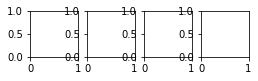

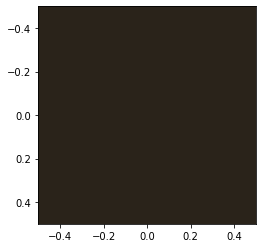

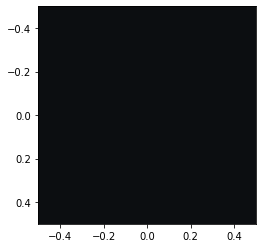

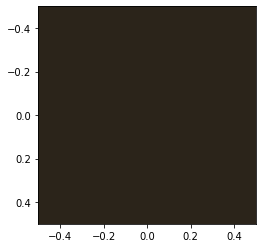

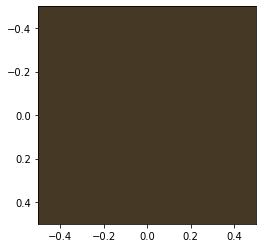

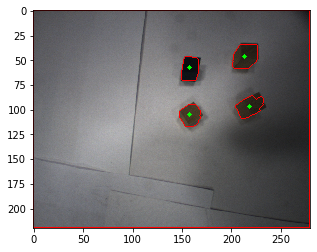

In [192]:
t = time.time()
image= cv2.imread("white_background1.png")
result, processed_image = get_centers(image)
print('total time: ' + str(time.time() - t))
im(processed_image)